# COVID19

In [2]:
# Importing Essential libraries
import os
import warnings
import plotly.express as px
import plotly.graph_objects as go
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, chi2_contingency, f_oneway
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot

# Suppress warnings:
def warn(*args, **kwargs):
    pass

warnings.warn = warn

## 1. Introduction

The COVID-19 pandemic has underscored the critical role of data science in informing public
health responses. Despite global efforts, inconsistencies in reporting, regional disparities in
outcomes, and gaps in resource allocation persist. This project aims to harness heterogeneous
pandemic datasets to identify anomalies, predict trends, optimize healthcare resources, and
uncover causal factors driving regional performance variations (e.g., Bangalore vs.
Mumbai/Delhi). By integrating advanced analytics with causal inference, we seek to provide
actionable insights for policymakers and healthcare stakeholders.

## 2. Objectives

The main objective of this notebook is to analyze and understand the impact of COVID-19 using data science techniques. It aims to bring together various pandemic-related datasets to find unusual patterns, predict future trends, and optimize the use of healthcare resources. The analysis also focuses on identifying the reasons behind different outcomes in various regions, such as differences between cities like Bangalore, Mumbai, and Delhi. By applying advanced analytics and causal inference, the notebook seeks to provide clear and useful insights that can help policymakers and healthcare professionals make better decisions. Overall, the goal is to use data to support effective public health responses and improve outcomes during the pandemic

## 3. Dataset Overview and Pre-Processing

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#### 3.1 Indian Vaccination Data

In [55]:
def clean_data(df):
    df.columns = df.columns.str.strip()
    df.fillna(0, inplace=True)
    return df
statewise_status = pd.read_csv("Dataset/covid19_India/statewiseStatus.csv")
statewise_status = clean_data(statewise_status)
statewise_status.head()

,State/UTs,Total Cases,Active,Discharged,Deaths,Active Ratio,Discharge Ratio,Death Ratio
0,Maharashtra,8176044,213,8027241,148590,0.00%,98.18%,1.82%
1,Kerala,6917577,13,6845461,72103,0.00%,98.96%,1.04%
2,Karnataka,4095971,80,4055493,40398,0.00%,99.01%,0.99%
3,Tamil Nadu,3611584,10,3573488,38086,0.00%,98.95%,1.05%
4,Andhra Pradesh,2341083,5,2326345,14733,0.00%,99.37%,0.63%


The table presents a summary of COVID-19 statistics for Indian states. Maharashtra has the highest total cases and deaths, but its discharge ratio remains strong at over 98%, with a death ratio of 1.82%. Kerala and Karnataka also show high recovery rates above 98%, with death ratios just above or below 1%. All listed states currently report extremely low active case ratios, indicating that the majority of cases have either recovered or resulted in death. Overall, these figures reflect the significant impact of the pandemic in these states, but also highlight successful recovery efforts and the current containment of active cases.

#### 3.2 Indian Cases Data

In [56]:
statewise_vaccine = pd.read_csv("Dataset/covid19_India/statewiseVaccine.csv")
statewise_vaccine = clean_data(statewise_vaccine)
merged_data = pd.merge(statewise_status, statewise_vaccine, on="State/UTs", how="outer")
merged_data.fillna(0, inplace=True)
statewise_vaccine.head()

,State/UTs,Total Doses,Dose1,Dose 2,Dose 1 15-18,Dose 2 15-18,Dose 1 12-14,Dose 2 12-14,Precaution 18-59,Precaution
0,Andaman and Nicobar,991264,313284,320383,19208,18860,15124,14042,236936,53427
1,Andhra Pradesh,111045263,40645719,43555752,2535344,2527613,1537424,1496426,12121661,6625324
2,Arunachal Pradesh,1924584,861396,748505,59100,44869,40852,28445,81191,60226
3,Assam,50335778,22550941,20575569,1262520,972402,999552,602283,2108179,1264332
4,Bihar,157293060,62956601,59160917,6240650,5348480,4288630,3403195,12022680,3871907


The table provides a comprehensive overview of COVID-19 vaccination progress across different Indian states and union territories. With detailed columns for total doses, first and second doses, and age-specific vaccination data, this dataset allows for in-depth analysis of vaccine distribution and coverage. By examining these figures, one can assess the effectiveness of vaccination campaigns, identify regions with lower coverage, and prioritize areas needing more resources. This data can also be used to track the uptake of precautionary doses and understand vaccination trends among different age groups. Overall, such insights are crucial for guiding public health strategies and ensuring equitable vaccine access across the country.

In [57]:
merged_data.head()

,State/UTs,Total Cases,Active,Discharged,Deaths,Active Ratio,Discharge Ratio,Death Ratio,Total Doses,Dose1,Dose 2,Dose 1 15-18,Dose 2 15-18,Dose 1 12-14,Dose 2 12-14,Precaution 18-59,Precaution
0,Andaman and Nicobar,10766.0,0.0,10637.0,129.0,0.00%,98.80%,1.20%,991264.0,313284.0,320383.0,19208.0,18860.0,15124.0,14042.0,236936.0,53427.0
1,Andhra Pradesh,2341083.0,5.0,2326345.0,14733.0,0.00%,99.37%,0.63%,111045263.0,40645719.0,43555752.0,2535344.0,2527613.0,1537424.0,1496426.0,12121661.0,6625324.0
2,Arunachal Pradesh,67049.0,0.0,66753.0,296.0,0.00%,99.56%,0.44%,1924584.0,861396.0,748505.0,59100.0,44869.0,40852.0,28445.0,81191.0,60226.0
3,Assam,746225.0,2.0,738187.0,8036.0,0.00%,98.92%,1.08%,50335778.0,22550941.0,20575569.0,1262520.0,972402.0,999552.0,602283.0,2108179.0,1264332.0
4,Bihar,855420.0,24.0,843081.0,12315.0,0.00%,98.56%,1.44%,157293060.0,62956601.0,59160917.0,6240650.0,5348480.0,4288630.0,3403195.0,12022680.0,3871907.0


#### 3.3 Hospital data

In [9]:
hospital_df = pd.read_csv('dataset_apollo.csv')
hospital_df.head()

,Unnamed: 0,age,sex,smoker,region,viral load,severity level,hospitalization charges
0,0,19,female,yes,southwest,9.30,0,42212
1,1,18,male,no,southeast,11.26,1,4314
2,2,28,male,no,southeast,11.00,3,11124
3,3,33,male,no,northwest,7.57,0,54961
4,4,32,male,no,northwest,9.63,0,9667


In [10]:
hospital_df.isnull().sum() # No null value is present

Unnamed: 0                 0
age                        0
sex                        0
smoker                     0
region                     0
viral load                 0
severity level             0
hospitalization charges    0
dtype: int64

#### 3.4 Global Case Dataset

In [58]:

path = 'Dataset/covid_19_clean_complete.csv'

if os.path.exists(path):
    df = pd.read_csv(path)
    print("File loaded successfully.")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['Province/State'] = df['Province/State'].fillna('Unknown')
    df = df.dropna(subset=['Country/Region', 'Lat', 'Long', 'Confirmed', 'Deaths', 'Recovered'])
    df['Country/Region'] = df['Country/Region'].str.strip()
    df = df.drop_duplicates()
    df = df.reset_index(drop=True)

    print("\nCleaned Dataset Info:")
    print(df.info())
    print("\nFirst 3 Rows of Cleaned Data:")
    print(df.head(3))
    
else:
    print("File not found. Please check the path:", path)


File loaded successfully.

Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16874 entries, 0 to 16873
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  16874 non-null  object        
 1   Country/Region  16874 non-null  object        
 2   Lat             16874 non-null  float64       
 3   Long            16874 non-null  float64       
 4   Date            16874 non-null  datetime64[ns]
 5   Confirmed       16874 non-null  int64         
 6   Deaths          16874 non-null  int64         
 7   Recovered       16874 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 1.0+ MB
None

First 3 Rows of Cleaned Data:
  Province/State Country/Region      Lat      Long       Date  Confirmed  \
0        Unknown       Thailand  15.0000  101.0000 2020-01-22          2   
1        Unknown          Japan  36.0000  138.0000 202

In [59]:
df = pd.read_csv('Dataset/covid_19_clean_complete.csv')
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')

global_daily = df.groupby("Date")[["Confirmed", "Deaths", "Recovered"]].sum()
latest = global_daily.iloc[-1]
latest_date = global_daily.index[-1].date()

print(f"\n Global COVID-19 Situation (as of {latest_date}):")
print(f"Total Confirmed Cases: {int(latest['Confirmed']):,}")
print(f"Total Deaths: {int(latest['Deaths']):,}")
print(f"Total Recovered: {int(latest['Recovered']):,}")

country_totals = df[df['Date'] == df['Date'].max()].groupby('Country/Region')[["Confirmed", "Deaths", "Recovered"]].sum()
country_totals_sorted = country_totals.sort_values(by='Confirmed', ascending=False)

print("\nCountry-wise Totals (first 5 rows):")
print(country_totals_sorted.head().to_string())



 Global COVID-19 Situation (as of 2020-03-20):
Total Confirmed Cases: 272,166
Total Deaths: 11,299
Total Recovered: 87,256

Country-wise Totals (first 5 rows):
                Confirmed  Deaths  Recovered
Country/Region                              
China               81250    3253      71266
Italy               47021    4032       4440
Spain               20410    1043       1588
Germany             19848      67        180
Iran                19644    1433       6745


This code processes and summarizes COVID-19 data to provide both a global overview and country-wise breakdown of confirmed cases, deaths, and recoveries. By organizing and displaying this information, it enables users to quickly identify patterns and compare the impact of the pandemic across different countries. Such analysis helps in tracking the spread of the virus, evaluating the effectiveness of interventions, and prioritizing areas that may need more resources or attention. The insights gained from this data can guide public health decisions and inform future strategies for managing outbreaks.

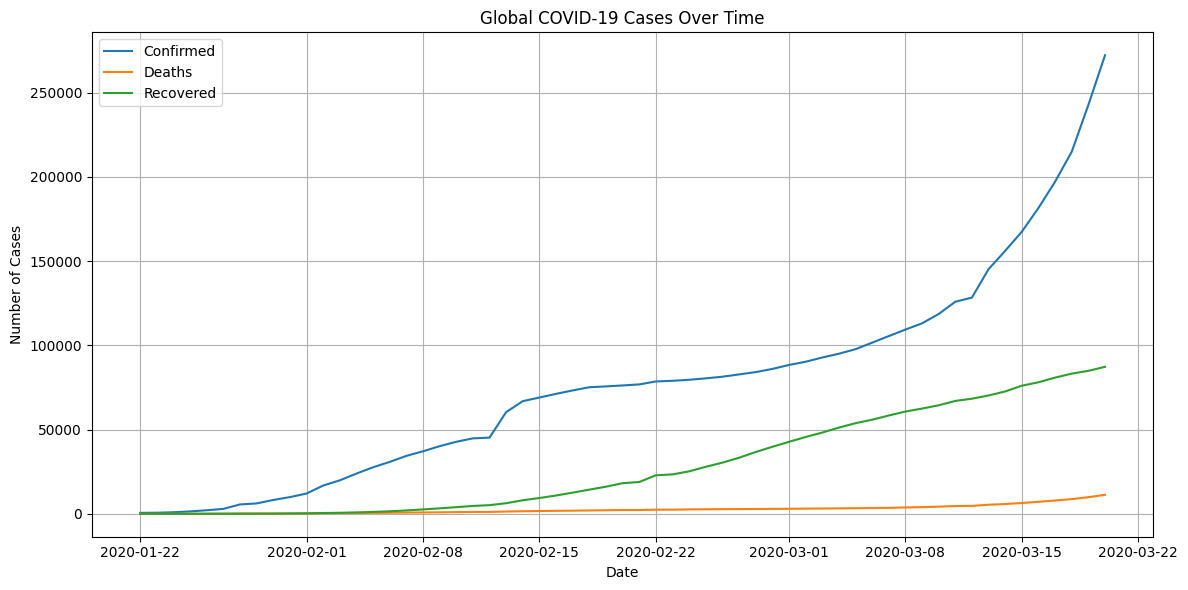

In [60]:

global_daily = df.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(global_daily['Date'], global_daily['Confirmed'], label='Confirmed')
plt.plot(global_daily['Date'], global_daily['Deaths'], label='Deaths')
plt.plot(global_daily['Date'], global_daily['Recovered'], label='Recovered')

plt.title('Global COVID-19 Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This line graph visualizes the global trends of confirmed, recovered, and death cases of COVID-19 over time. By examining these trends, one can observe how quickly the virus spread, how recovery rates changed, and how the number of deaths evolved. Such visualization helps identify key moments when cases surged or when recovery efforts became more effective. This information can be used to evaluate the impact of interventions, guide future public health strategies, and communicate the seriousness of the situation to the public and policymakers

#### 3.5 Global Time-Series Data

The Time-Series Data (Global) dataset provides daily cumulative counts of confirmed COVID-19 cases, recoveries, and deaths across various countries and regions, from date 22nd January, 2020 to 20th March, 2020.

In [3]:
global_df_confirmed = pd.read_csv('./Dataset/Global Timeseries/time_series_covid_19_confirmed.csv')
global_df_deaths = pd.read_csv('./Dataset/Global Timeseries/time_series_covid_19_deaths.csv')
global_df_recovered = pd.read_csv('./Dataset/Global Timeseries/time_series_covid_19_recovered.csv')

In [4]:
global_df_confirmed.shape,global_df_deaths.shape,global_df_recovered.shape

((477, 63), (477, 63), (477, 63))

In [5]:
global_df_confirmed.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,59,70,75,82,114,147,177,212,272,322
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,639,701,773,839,825,878,889,924,963
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,178,200,212,226,243,266,313,345,385
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,149,197,238,428,566,673,790,900,1030


In [6]:
global_df_deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,NaN,Japan,36.0000,138.0000,0,0,0,0,0,0,...,15,16,19,22,22,27,29,29,29,33
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2,2,3


In [7]:
global_df_recovered.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
0,NaN,Thailand,15.0000,101.0000,0,0,0,0,2,2,...,34,34,35,35,35,35,41,42,42,42
1,NaN,Japan,36.0000,138.0000,0,0,0,0,1,1,...,118,118,118,118,118,144,144,144,150,191
2,NaN,Singapore,1.2833,103.8333,0,0,0,0,0,0,...,96,96,97,105,105,109,114,114,114,124
3,NaN,Nepal,28.1667,84.2500,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,0,0,0,...,26,26,26,35,42,42,49,60,75,87


This dataset provides a time series of COVID-19 case counts for different countries, along with their geographic coordinates. By analyzing this data, one can track how the virus spread over time in various regions and compare the progression between countries. The information can be used to create visualizations such as line graphs or maps, helping to identify trends, outbreak hotspots, and the effectiveness of interventions. Additionally, this structured data supports forecasting, resource planning, and deeper epidemiological studies to guide public health responses.

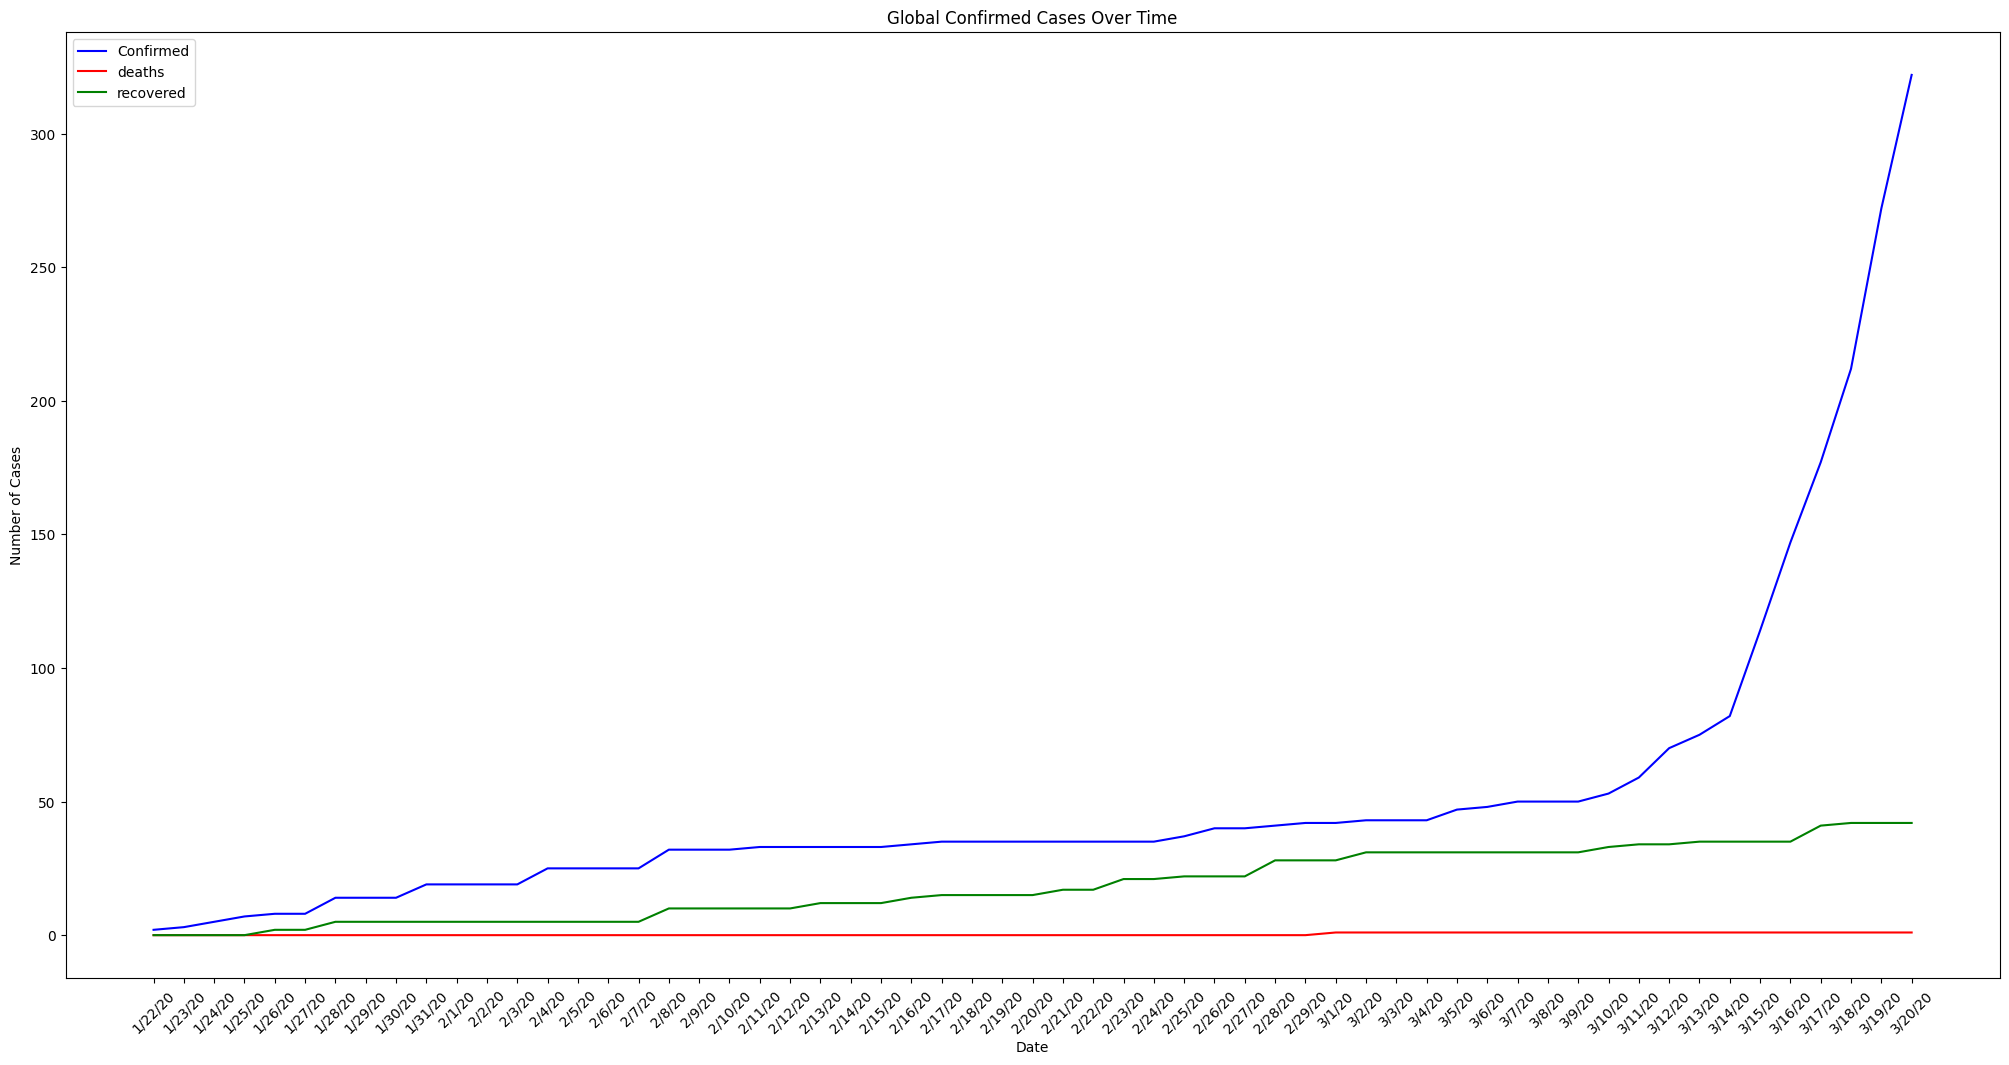

In [8]:
plt.figure(figsize=(20, 10))
plt.plot(global_df_confirmed.iloc[0,4:], label='Confirmed', color='blue')
plt.plot(global_df_deaths.iloc[0,4:], label='deaths', color='red')
plt.plot(global_df_recovered.iloc[0,4:], label='recovered', color='green')
plt.tight_layout()
plt.title('Global Confirmed Cases Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.xticks(rotation=45)
plt.show()

This line graph shows the progression of confirmed, recovered, and death cases of COVID-19 over time. By analyzing this visualization, one can observe how the situation evolved and identify periods of rapid change or stability. Such a graph is useful for monitoring trends, assessing the effectiveness of interventions, and making informed decisions about future actions. It can also help communicate the seriousness of the outbreak and the importance of continued public health measures to both policymakers and the general public.

## 4. Exploratory Data Analysis (EDA)

#### 4.1 Vaccination Distribution Across Indian States


#### 4.2 COVID-19 Case Severity by State


In [67]:
def create_choropleth(data, column, title):
    fig = px.choropleth(
        data,
        geojson="https://gist.githubusercontent.com/jbrobst/56c13bbbf9d97d187fea01ca62ea5112/raw/e388c4cae20aa53cb5090210a42ebb9b765c0a36/india_states.geojson",
        featureidkey='properties.ST_NM',
        locations='State/UTs',
        color=column,
        color_continuous_scale='Reds',
        title=title
    )
    fig.update_geos(fitbounds="locations", visible=False)
    return fig

def create_state_comparison_bar(data, column, title, top_n=10):
    sorted_data = data.sort_values(column, ascending=False).head(top_n)
    fig = px.bar(
        sorted_data,
        y='State/UTs',
        x=column,
        title=f"Top {top_n} States/UTs by {title}",
        orientation='h',
        color=column,
        color_continuous_scale='Viridis'
    )
    return fig

def create_scatter_plot(data, x_col, y_col, size_col, title):
    fig = px.scatter(
        data,
        x=x_col,
        y=y_col,
        size=size_col,
        color='State/UTs',
        hover_name='State/UTs',
        title=title,
        size_max=60
    )
    return fig

def create_vaccination_progress(data):
    data['Dose1_Percentage'] = (data['Dose1'] / data['Total Doses']) * 100
    data['Dose2_Percentage'] = (data['Dose 2'] / data['Total Doses']) * 100
    
    top_states = data.sort_values('Total Doses', ascending=False).head(15)
    
    fig = go.Figure()
    fig.add_trace(go.Bar(
        y=top_states['State/UTs'],
        x=top_states['Dose1_Percentage'],
        name='Dose 1',
        orientation='h',
        marker=dict(color='rgba(58, 71, 80, 0.6)')
    ))
    
    fig.add_trace(go.Bar(
        y=top_states['State/UTs'],
        x=top_states['Dose2_Percentage'],
        name='Dose 2',
        orientation='h',
        marker=dict(color='rgba(246, 78, 139, 0.6)')
    ))
    
    fig.update_layout(
        title='Vaccination Progress (Top 15 States)',
        barmode='stack',
        xaxis_title='Percentage',
        yaxis_title='State/UT'
    )
    return fig

def test_hypothesis():
    analysis_data = merged_data.copy()
    
    if analysis_data['Death Ratio'].dtype == 'object':
        analysis_data['Death Ratio'] = analysis_data['Death Ratio'].astype(str).str.rstrip('%').astype(float)
    
    if analysis_data['Active Ratio'].dtype == 'object':
        analysis_data['Active Ratio'] = analysis_data['Active Ratio'].astype(str).str.rstrip('%').astype(float)
    
    analysis_data['Vaccination_Rate'] = (analysis_data['Dose1'] + analysis_data['Dose 2']) / 100000  # per 100k people
    
    correlation = analysis_data['Vaccination_Rate'].corr(analysis_data['Death Ratio'])
    active_death_corr = analysis_data['Active Ratio'].corr(analysis_data['Death Ratio'])
    
    fig1 = px.scatter(
        analysis_data,
        x='Vaccination_Rate',
        y='Death Ratio',
        size='Total Cases',
        color='State/UTs',
        hover_name='State/UTs',
        trendline='ols',
        title=f'Hypothesis 1: Vaccination Rate vs Death Ratio (Correlation: {correlation:.2f})'
    )
    
    fig2 = px.scatter(
        analysis_data,
        x='Active Ratio',
        y='Death Ratio',
        size='Total Cases',
        color='State/UTs',
        hover_name='State/UTs',
        trendline='ols',
        title=f'Hypothesis 2: Active Ratio vs Death Ratio (Correlation: {active_death_corr:.2f})'
    )
    
    return fig1, fig2, correlation, active_death_corr


In [68]:
fig1 = create_choropleth(statewise_status, 'Total Cases', 'COVID-19 Total Cases by State')
fig1.show()

This map visually represents the distribution of COVID-19 cases across different states in India, using color intensity to indicate the number of cases in each region. By examining this geographic visualization, one can quickly identify which states have been most affected and spot regional patterns or clusters. Such insights are valuable for targeting public health interventions, allocating resources efficiently, and understanding how the virus has spread spatially. This type of map also helps policymakers and health officials prioritize areas that may require additional support or preventive measures.

In [69]:

# Top 10 States by Cases - Bar Chart
fig2 = create_state_comparison_bar(statewise_status, 'Total Cases', 'COVID-19 Total Cases')
fig2.show()


This bar chart highlights the top 10 Indian states and union territories with the highest total COVID-19 cases, using color gradients to visually differentiate the case counts. By analyzing this visualization, one can quickly identify which regions have experienced the greatest impact from the pandemic and compare the relative burden across states. Such insights are valuable for understanding regional trends, guiding resource allocation, and prioritizing public health interventions where they are needed most. This information can also help policymakers focus on strengthening healthcare infrastructure and preventive measures in the most affected areas.

In [70]:

fig3 = create_state_comparison_bar(statewise_status, 'Death Ratio', 'Death Ratio (%)')
fig3.show()

This bar chart visually compares the death ratios of the top 10 Indian states and union territories most affected by COVID-19 mortality. By focusing on the proportion of deaths rather than absolute numbers, the chart highlights regions where the disease has been particularly severe or where healthcare challenges may have contributed to higher mortality. Such insights can prompt further investigation into local healthcare systems, public health responses, and demographic factors influencing outcomes. This information is valuable for identifying areas that may benefit from targeted interventions, improved medical resources, or policy changes to reduce future risks.

In [71]:
# Vaccination Progress
fig4 = create_vaccination_progress(statewise_vaccine)
fig4.show()


This bar chart illustrates the comparative progress of first and second dose COVID-19 vaccinations across the top 15 Indian states and union territories. The visualization highlights not only the overall reach of the vaccination campaign but also reveals gaps between initial and complete immunization. By identifying states where the uptake of the second dose lags behind the first, stakeholders can focus efforts on closing this gap to ensure better protection for the population. This insight is crucial for designing targeted awareness campaigns and optimizing resource allocation to achieve full vaccination coverage.

In [75]:
# Summary of findings
print("\n Analysis Summary ")

# Top 5 states by cases
top_cases = statewise_status.sort_values('Total Cases', ascending=False).head(5)
print(f"\nTop 5 states by total COVID-19 cases:")
for i, row in enumerate(top_cases.itertuples()):
    print(f"{i+1}. {row._1}: {int(row._2):,} cases")

# Top 5 states by death ratio
# Modified code to handle Death Ratio as string
status_copy = statewise_status.copy()
if status_copy['Death Ratio'].dtype == 'object':
    # Just display the string value directly without formatting
    top_death_ratio = status_copy.sort_values('Death Ratio', ascending=False).head(5)
    print(f"\nTop 5 states by death ratio:")
    for i, row in enumerate(top_death_ratio.itertuples()):
        print(f"{i+1}. {row._1}: {row._7}")
else:
    # If it's already a numeric value, format it
    top_death_ratio = status_copy.sort_values('Death Ratio', ascending=False).head(5)
    print(f"\nTop 5 states by death ratio:")
    for i, row in enumerate(top_death_ratio.itertuples()):
        print(f"{i+1}. {row._1}: {row._7:.2f}%")

# Top 5 states by vaccination
top_vaccination = statewise_vaccine.sort_values('Total Doses', ascending=False).head(5)
print(f"\nTop 5 states by vaccination doses:")
for i, row in enumerate(top_vaccination.itertuples()):
    print(f"{i+1}. {row._1}: {int(row._2):,} doses")

# Hypothesis results
print("\nHypothesis Testing Results:")
print(f"1. Correlation between vaccination rate and death ratio: {corr1:.3f}")
if abs(corr1) > 0.5:
    print("   There is a significant correlation between vaccination rates and death ratios.")
else:
    print("   There is a weak correlation between vaccination rates and death ratios.")

print(f"2. Correlation between active ratio and death ratio: {corr2:.3f}")
if abs(corr2) > 0.5:
    print("   There is a significant correlation between active cases and death ratios.")
else:
    print("   There is a weak correlation between active cases and death ratios.")



 Analysis Summary 

Top 5 states by total COVID-19 cases:
1. Maharashtra: 8,176,044 cases
2. Kerala: 6,917,577 cases
3. Karnataka: 4,095,971 cases
4. Tamil Nadu: 3,611,584 cases
5. Andhra Pradesh: 2,341,083 cases

Top 5 states by death ratio:
1. Punjab: 97.41%
2. Nagaland: 97.83%
3. Maharashtra: 98.18%
4. Uttarakhand: 98.28%
5. Meghalaya: 98.32%

Top 5 states by vaccination doses:
1. Uttar Pradesh: 392,012,573 doses
2. Maharashtra: 177,984,195 doses
3. Bihar: 157,293,060 doses
4. West Bengal: 156,100,540 doses
5. Madhya Pradesh: 133,940,233 doses

Hypothesis Testing Results:
1. Correlation between vaccination rate and death ratio: 0.083
   There is a weak correlation between vaccination rates and death ratios.
2. Correlation between active ratio and death ratio: 0.018
   There is a weak correlation between active cases and death ratios.


#### 4.3 Global Trend Analysis


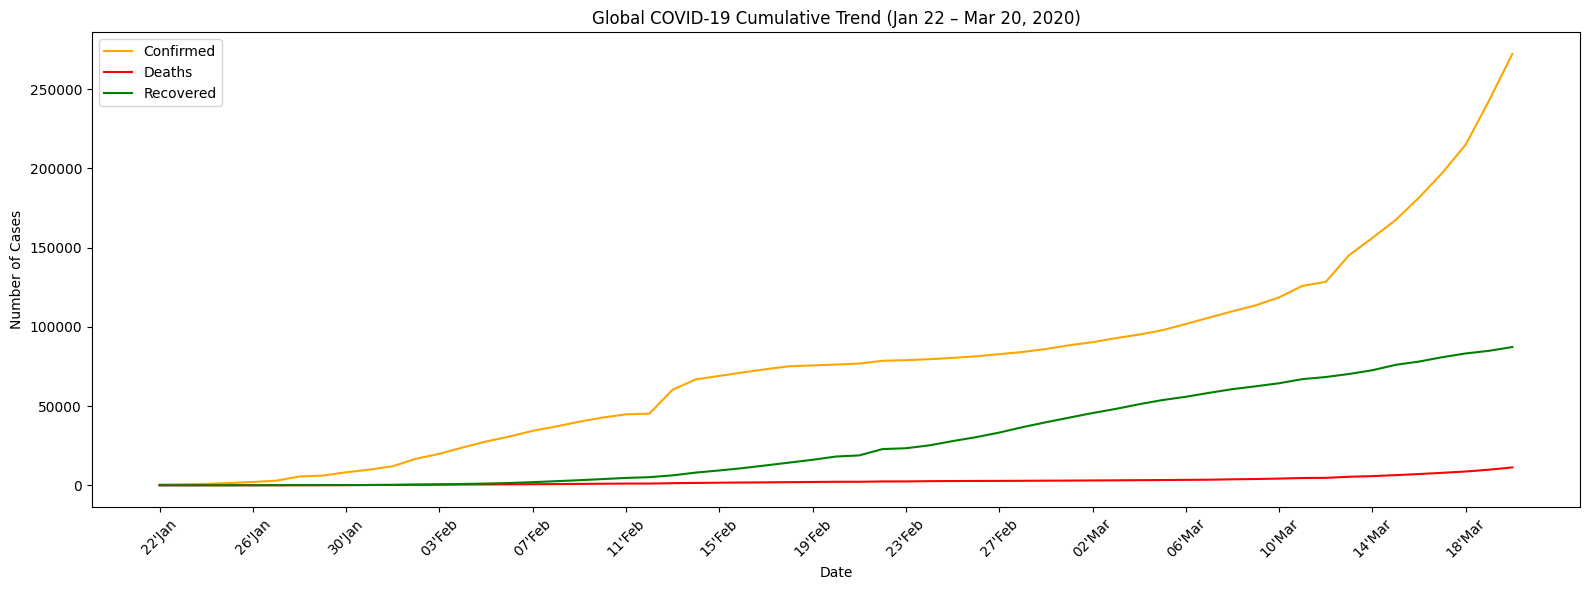

In [13]:
dates = global_df_confirmed.columns[4:]
total_confirmed = global_df_confirmed[dates].sum()
total_deaths = global_df_deaths[dates].sum()
total_recovered = global_df_recovered[dates].sum()

date_fmt = pd.to_datetime(dates, format="%m/%d/%y")
formatted_dates = date_fmt.strftime("%d'%b")

plt.figure(figsize=(16,6))  # Extended width
plt.plot(formatted_dates, total_confirmed, label="Confirmed", color='orange')
plt.plot(formatted_dates, total_deaths, label="Deaths", color='red')
plt.plot(formatted_dates, total_recovered, label="Recovered", color='green')

# Show only every 4th date for better readability
plt.xticks(ticks=range(0, len(formatted_dates), 4), labels=formatted_dates[::4], rotation=45)

plt.title("Global COVID-19 Cumulative Trend (Jan 22 – Mar 20, 2020)")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.legend()
plt.tight_layout()
plt.show()

This global trend graph visually demonstrates the cumulative progression of confirmed, recovered, and death cases of COVID-19 over time. By observing the distinct slopes and separation between the lines, one can gain insight into the dynamic relationship between virus transmission, recovery rates, and mortality worldwide. The visualization helps identify periods of rapid escalation and can prompt further investigation into the effectiveness of global interventions or policy changes. Such a chart is valuable for communicating the urgency of the pandemic and supporting international collaboration in response efforts

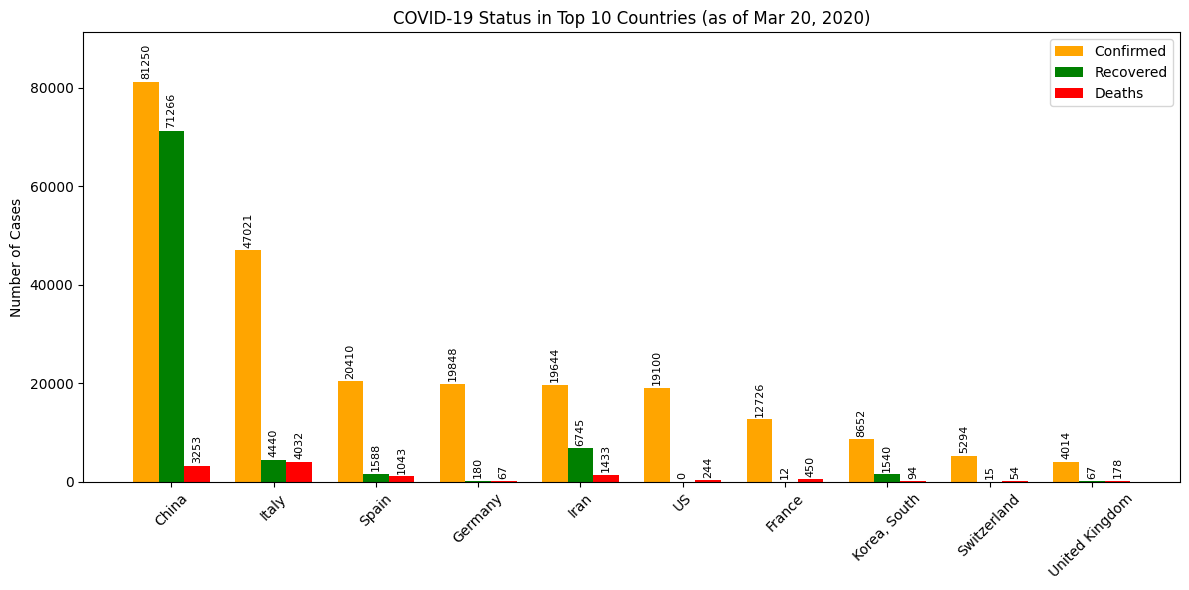

In [17]:
last_date = global_df_confirmed.columns[-1]

confirmed = global_df_confirmed.groupby("Country/Region")[last_date].sum()
recovered = global_df_recovered.groupby("Country/Region")[last_date].sum()
deaths = global_df_deaths.groupby("Country/Region")[last_date].sum()

top_countries = confirmed.sort_values(ascending=False).head(10).index

confirmed_top = confirmed[top_countries]
recovered_top = recovered[top_countries]
deaths_top = deaths[top_countries]

x = np.arange(len(top_countries))
width = 0.25

plt.figure(figsize=(12,6))
bars1 = plt.bar(x - width, confirmed_top, width=width, label='Confirmed', color='orange')
bars2 = plt.bar(x, recovered_top, width=width, label='Recovered', color='green')
bars3 = plt.bar(x + width, deaths_top, width=width, label='Deaths', color='red')

# Increase Y-axis height
max_height = max(confirmed_top.max(), recovered_top.max(), deaths_top.max())
plt.ylim(0, max_height + 10000)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 500, f'{int(height)}', 
                 ha='center', va='bottom', fontsize=8, rotation=90)

plt.xticks(x, top_countries, rotation=45)
plt.title("COVID-19 Status in Top 10 Countries (as of Mar 20, 2020)")
plt.ylabel("Number of Cases")
plt.legend()
plt.tight_layout()
plt.show()

This bar chart provides a comparative overview of confirmed, recovered, and death cases in the top 10 countries most affected by COVID-19 as of March 2020. By displaying all three metrics side by side, it highlights disparities in recovery and mortality outcomes across different nations. This visualization enables stakeholders to identify which countries managed to achieve higher recovery rates or struggled with higher fatalities, suggesting potential differences in healthcare responses, preparedness, or public health strategies. Such insights can inform global collaboration, encourage the sharing of effective practices, and guide targeted support to regions facing greater challenges.

In [23]:
last_date = global_df_confirmed.columns[-1]

confirmed = global_df_confirmed.groupby('Country/Region')[last_date].sum()
deaths = global_df_deaths.groupby('Country/Region')[last_date].sum()
recovered = global_df_recovered.groupby('Country/Region')[last_date].sum()

world_df = pd.DataFrame({
    'Country': confirmed.index,
    'Confirmed': confirmed.values,
    'Deaths': deaths[confirmed.index].values,
    'Recovered': recovered[confirmed.index].values
})

fig = go.Figure()

# Confirmed
fig.add_trace(go.Choropleth(
    locations=world_df['Country'],
    locationmode='country names',
    z=world_df['Confirmed'],
    colorscale='Oranges',
    colorbar_title='Confirmed',
    visible=True,
    name='Confirmed'
))

# Deaths
fig.add_trace(go.Choropleth(
    locations=world_df['Country'],
    locationmode='country names',
    z=world_df['Deaths'],
    colorscale='Reds',
    colorbar_title='Deaths',
    visible=False,
    name='Deaths'
))

# Recovered
fig.add_trace(go.Choropleth(
    locations=world_df['Country'],
    locationmode='country names',
    z=world_df['Recovered'],
    colorscale='Greens',
    colorbar_title='Recovered',
    visible=False,
    name='Recovered'
))

fig.update_layout(
    title_text='Global COVID-19 Cases (as of March 20, 2020)',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular',
    ),
    autosize=False,
    width=1200,
    height=700,
    margin=dict(l=50, r=50, t=100, b=50),
    updatemenus=[
        dict(
            buttons=[
                dict(label="Confirmed", method="update",
                     args=[{"visible": [True, False, False]},
                           {"title": "Confirmed COVID-19 Cases"}]),
                dict(label="Deaths", method="update",
                     args=[{"visible": [False, True, False]},
                           {"title": "COVID-19 Deaths"}]),
                dict(label="Recovered", method="update",
                     args=[{"visible": [False, False, True]},
                           {"title": "Recovered COVID-19 Cases"}])
            ],
            direction="down",
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.05,
            yanchor="top"
        )
    ]
)

fig.show()


This global map visualization offers a clear picture of how COVID-19 cases were distributed across different countries at an early stage of the pandemic. By using color intensity to represent case concentration, it highlights not only the initial epicenters but also the pattern of international spread. Such a map is valuable for understanding the geographic progression of outbreaks and can inform future strategies for border control, travel advisories, and resource allocation. It also emphasizes the importance of global coordination and rapid response to emerging health threats.

#### 4.4 Hospital

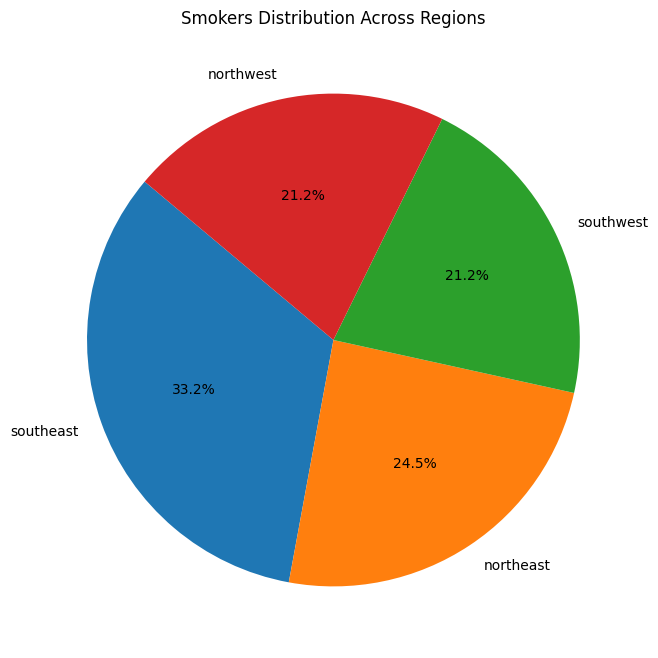

In [14]:
smokers = hospital_df.query('smoker=="yes"')
non_smokers = hospital_df.query('smoker=="no"')
smokers["region"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", startangle=140, figsize=(8, 8)
)
plt.ylabel("")
plt.title("Smokers Distribution Across Regions")
plt.show()

The pie chart illustrates the regional distribution of smokers, revealing that smoking habits are not evenly spread across different areas. This uneven distribution suggests that cultural, social, or environmental factors unique to each region may influence smoking behavior. Understanding these patterns can help design more effective, region-specific public health campaigns and interventions to reduce smoking rates where they are most prevalent

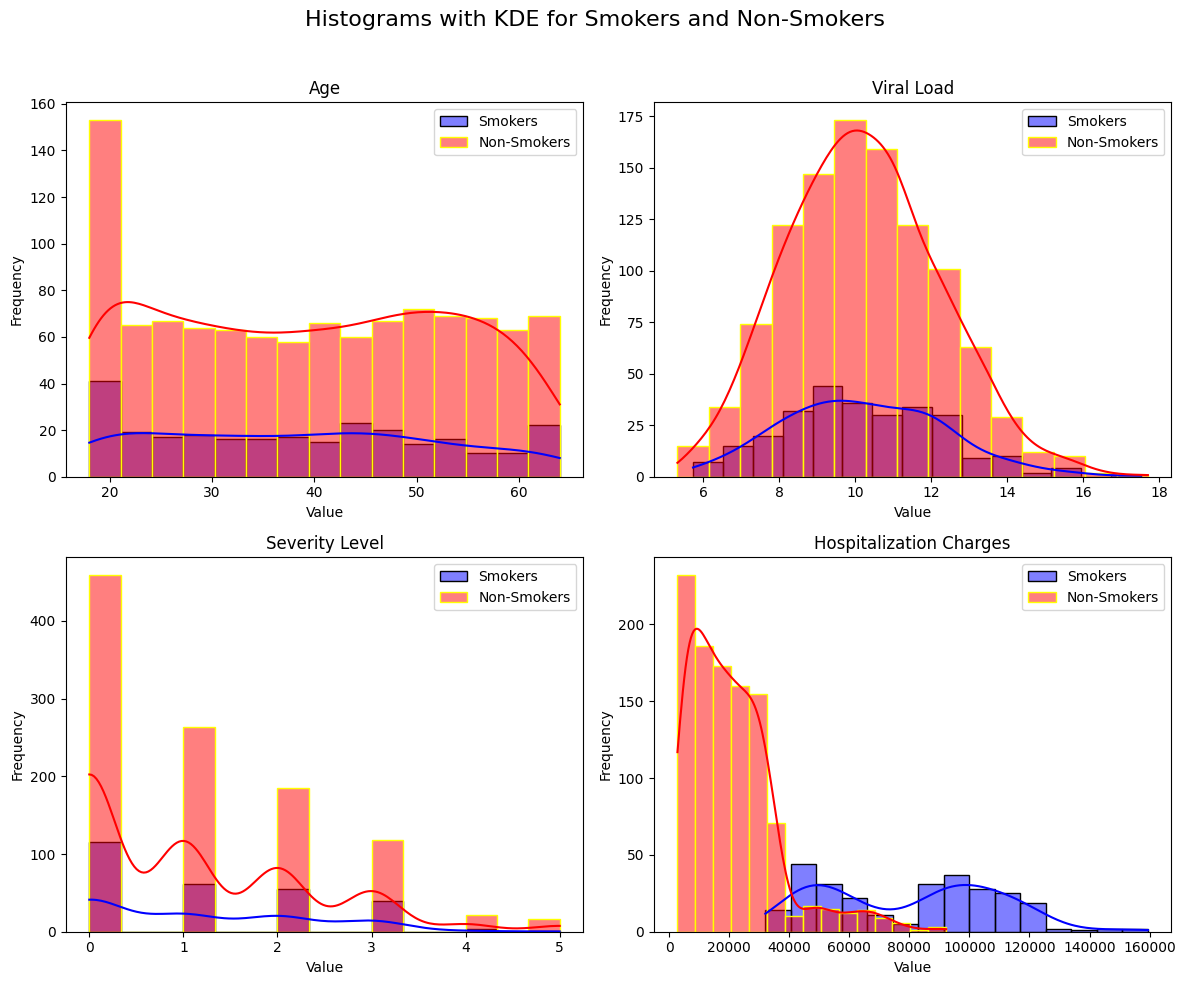

In [19]:
# Defining the numeric columns for plotting
numeric_columns = ["age", "viral load", "severity level", "hospitalization charges"]

# Plotting histograms with KDE lines for the numeric variables for both smokers and non-smokers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Histograms with KDE for Smokers and Non-Smokers", fontsize=16)

for ax, column in zip(axes.flatten(), numeric_columns):
    sns.histplot(
        smokers[column],
        kde=True,
        bins=15,
        edgecolor="black",
        color="blue",
        label="Smokers",
        ax=ax,
    )
    sns.histplot(
        non_smokers[column],
        kde=True,
        bins=15,
        edgecolor="yellow",
        color="red",
        label="Non-Smokers",
        ax=ax,
    )
    ax.set_title(column.title())
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The visualizations compare smokers and non-smokers across multiple health and economic dimensions, revealing that the two groups have distinctly different distributions in age, viral load, severity of illness, and hospitalization charges. These differences suggest that smoking status is closely linked with patterns of disease progression and healthcare utilization. The charts also highlight how lifestyle factors like smoking can create varying risk profiles within a patient population, which is important for hospitals when planning for resource needs and patient management. Such multi-dimensional analysis can help healthcare providers develop more personalized care strategies and preventative measures tailored to specific risk groups. Ultimately, these insights emphasize the value of integrating behavioral data into broader health analytics for more effective decision-making.

- Smokers have a higher average age.
- Smokers exhibit higher severity levels of illness.
- Smokers have a higher viral load.
- Smokers incur higher hospitalization charges.

In [22]:
# Bootstrapping
bootstrap_means = []
for _ in range(10000):  # Number of resamples
    boot_sample = resample(hospital_df["hospitalization charges"], replace=True)
    boot_mean = boot_sample.mean()
    bootstrap_means.append(boot_mean)

# Calculating 95% Confidence Interval
lower_bound = np.percentile(bootstrap_means, 2.5)
upper_bound = np.percentile(bootstrap_means, 97.5)

print(
    f"Interval for the mean hospital fees with 95% confidence is [{lower_bound}, {upper_bound}] "
)

Interval for the mean hospital fees with 95% confidence is [31586.34071375187, 34858.9360986547] 


In [46]:
hospital_cleaned = pd.get_dummies(
    hospital_df, columns=["sex", "smoker", "region"]
)

## 5. Comparative Analysis

#### 5.1 Indian States Comparison

In [76]:
def create_scatter_plot(data, x_col, y_col, size_col, title):
    fig = px.scatter(
        data,
        x=x_col,
        y=y_col,
        size=size_col,
        color='State/UTs',
        hover_name='State/UTs',
        title=title,
        size_max=60
    )
    return fig

def test_hypothesis():
    analysis_data = merged_data.copy()
    
    if analysis_data['Death Ratio'].dtype == 'object':
        analysis_data['Death Ratio'] = analysis_data['Death Ratio'].astype(str).str.rstrip('%').astype(float)
    
    if analysis_data['Active Ratio'].dtype == 'object':
        analysis_data['Active Ratio'] = analysis_data['Active Ratio'].astype(str).str.rstrip('%').astype(float)
    
    analysis_data['Vaccination_Rate'] = (analysis_data['Dose1'] + analysis_data['Dose 2']) / 100000  # per 100k people
    
    correlation = analysis_data['Vaccination_Rate'].corr(analysis_data['Death Ratio'])
    active_death_corr = analysis_data['Active Ratio'].corr(analysis_data['Death Ratio'])
    
    fig1 = px.scatter(
        analysis_data,
        x='Vaccination_Rate',
        y='Death Ratio',
        size='Total Cases',
        color='State/UTs',
        hover_name='State/UTs',
        trendline='ols',
        title=f'Hypothesis 1: Vaccination Rate vs Death Ratio (Correlation: {correlation:.2f})'
    )
    
    fig2 = px.scatter(
        analysis_data,
        x='Active Ratio',
        y='Death Ratio',
        size='Total Cases',
        color='State/UTs',
        hover_name='State/UTs',
        trendline='ols',
        title=f'Hypothesis 2: Active Ratio vs Death Ratio (Correlation: {active_death_corr:.2f})'
    )
    
    return fig1, fig2, correlation, active_death_corr


In [77]:
fig5 = create_scatter_plot(
    statewise_status, 
    'Discharge Ratio', 
    'Death Ratio', 
    'Total Cases',
    'Recovery Rate vs Death Rate by State (Size represents Total Cases)'
)
fig5.show()

This bubble chart visually compares the relationship between recovery rates and death rates for different regions, with bubble size reflecting the total number of cases. Such a visualization helps identify patterns in how effectively various regions managed the pandemic, revealing which areas achieved high recovery with lower mortality. It also highlights outliers that may warrant further investigation into healthcare practices or policy differences. This comparative approach supports states learning, enabling state to adopt successful strategies from others with similar challenges or outcomes

In [78]:
fig6, fig7, corr1, corr2 = test_hypothesis()
fig6.show()

This scatter plot explores the relationship between vaccination rates and death ratios across various Indian states and union territories, revealing a very weak correlation between the two. The visualization suggests that higher vaccination rates alone may not directly translate to lower death ratios, indicating the influence of other factors such as healthcare infrastructure, population demographics, or timely interventions. By highlighting this complexity, the chart encourages deeper investigation into what truly drives mortality outcomes beyond just vaccination coverage. Such insights are valuable for developing more holistic public health strategies that address multiple dimensions of pandemic response

In [79]:
fig7.show()


This scatter plot examines the relationship between the active case ratio and death ratio for various Indian states and union territories, revealing almost no correlation between the two. This suggests that the proportion of currently active cases in a region does not necessarily predict its death ratio, highlighting the complexity of pandemic outcomes. Such a finding points to the influence of additional factors—such as healthcare quality, early interventions, or demographic differences—that may play a more significant role in determining mortality rates. This insight encourages a broader, multifaceted approach to pandemic management rather than focusing on a single metric.

#### 5.2 India vs Global Trends

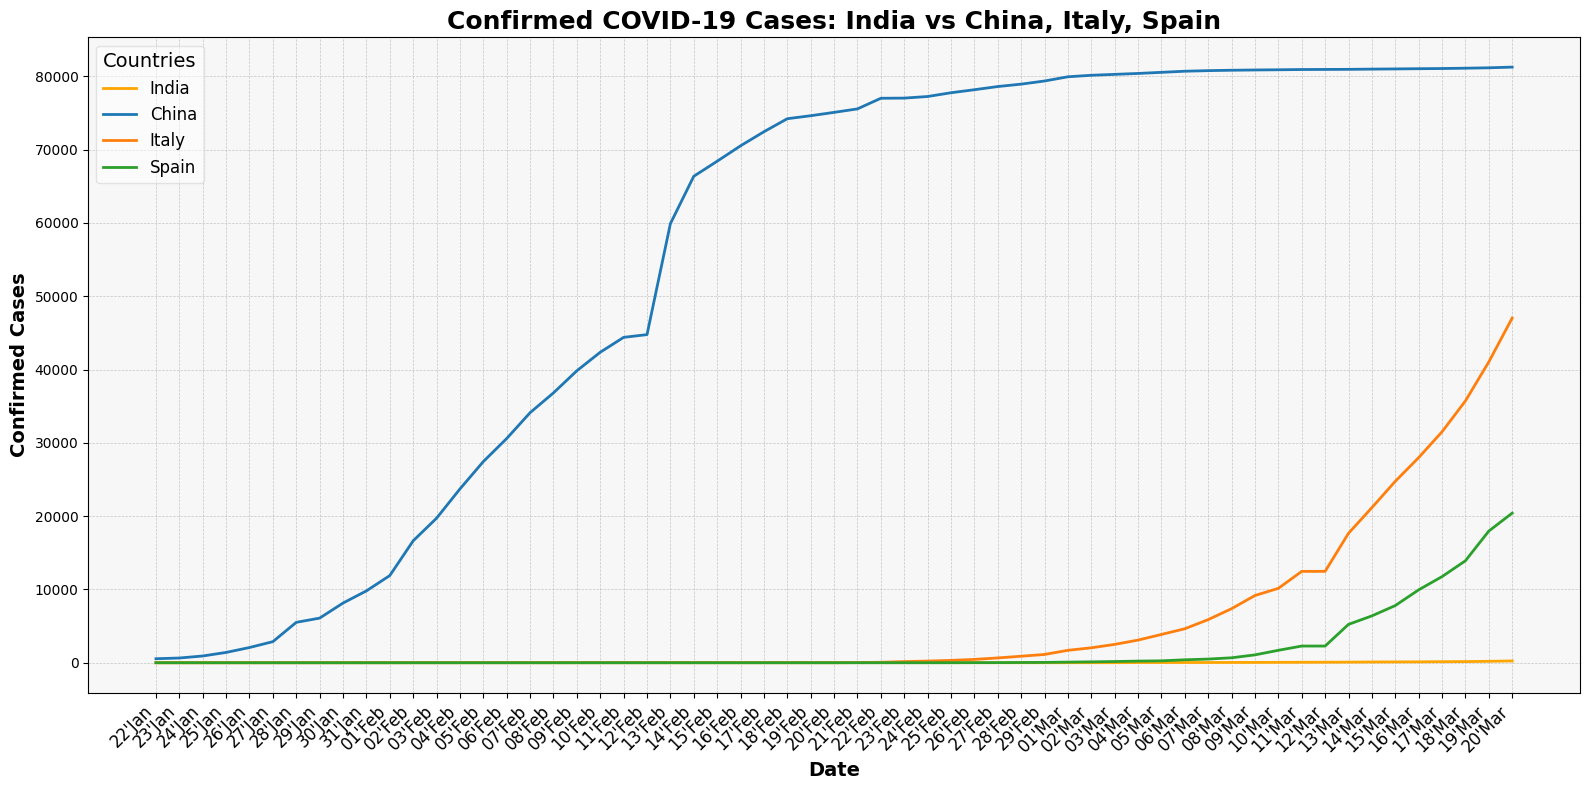

In [32]:
# Hardcode the countries for comparison
comparison_countries = ['China', 'Italy', 'Spain']

# Separate data for India and the selected countries (China, Italy, Spain)
india_confirmed = global_df_confirmed[global_df_confirmed['Country/Region'] == 'India']
comparison_countries_data = global_df_confirmed[global_df_confirmed['Country/Region'].isin(comparison_countries)]

# Sum over all provinces (if any)
india_confirmed_sum = india_confirmed[date_cols].sum()

# Sum of confirmed cases for the selected countries (China, Italy, Spain)
comparison_confirmed_sum = comparison_countries_data.groupby('Country/Region')[date_cols].sum()

# Plot comparison
fig, ax = plt.subplots(figsize=(16, 8))  # Extended figure size for better spacing

# Format dates
dates_fmt = pd.to_datetime(date_cols).strftime("%d'%b")

# Plot India Confirmed
ax.plot(dates_fmt, india_confirmed_sum, label='India', color='orange', linewidth=2)

# Plot Confirmed cases for the selected countries (China, Italy, Spain)
for country in comparison_countries:
    ax.plot(dates_fmt, comparison_confirmed_sum.loc[country], label=country, linewidth=2)

# Title and labels with enhanced styling
ax.set_title('Confirmed COVID-19 Cases: India vs China, Italy, Spain', fontsize=18, fontweight='bold')
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Confirmed Cases', fontsize=14, fontweight='bold')

# Adding gridlines and setting layout for better aesthetics
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f7f7f7')  # Subtle background color

# Improve the legend's position and appearance
ax.legend(title='Countries', loc='upper left', fontsize=12, title_fontsize=14, fancybox=True, framealpha=0.5)

# Rotate and format the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()


This comparative line graph of confirmed COVID-19 cases in India, China, Italy, and Spain highlights how the timing and pace of outbreaks differed dramatically across countries. The visual contrast in curve shapes suggests that early interventions, public health responses, and population behaviors played significant roles in shaping each country’s epidemic trajectory. It also underscores the importance of learning from international experiences—countries that acted swiftly with containment measures generally saw slower initial growth. Such cross-country comparisons are valuable for guiding future preparedness and response strategies, emphasizing that proactive policy decisions can alter the course of an outbreak

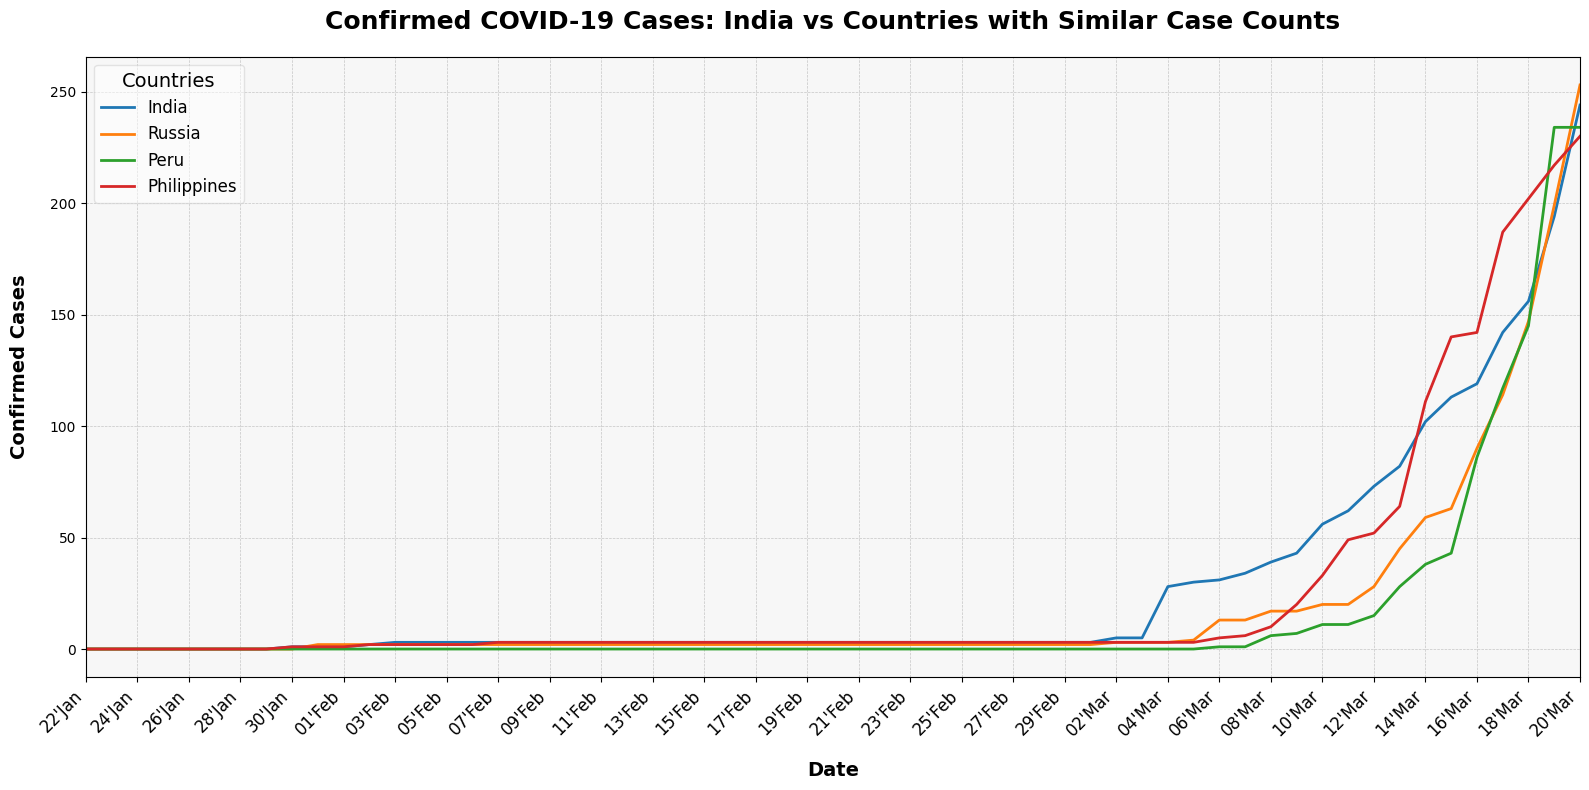

In [42]:
confirmed_by_country = global_df_confirmed.groupby("Country/Region")[date_cols].sum()

# Get the latest confirmed cases for each country (using the last date column)
latest_confirmed = confirmed_by_country.iloc[:, -1]

# Ensure the index (country names) are strings and remove any extra spaces.
latest_confirmed.index = latest_confirmed.index.astype(str).str.strip()

# Check if 'India' is in the data and extract India's confirmed cases.
if 'India' in latest_confirmed.index:
    india_confirmed_cases = latest_confirmed['India']
else:
    raise ValueError("India not found in the dataset. Please check the data.")

# Sort countries by confirmed cases in descending order.
sorted_confirmed = latest_confirmed.sort_values(ascending=False)

# Define a threshold range for "similar" confirmed cases (e.g., ±10% of India's count)
threshold = india_confirmed_cases * 0.1

# Identify countries with confirmed cases within ±10% of India's confirmed cases.
similar_confirmed = sorted_confirmed[(sorted_confirmed >= india_confirmed_cases - threshold) &
                                     (sorted_confirmed <= india_confirmed_cases + threshold)]

# Remove India from the similar countries list.
similar_confirmed = similar_confirmed.drop('India', errors='ignore')

# Combine India with the similar countries for comparison.
comparison_countries = ['India'] + similar_confirmed.index.tolist()

# Extract time series data (over the provided date columns) for the comparison countries.
comparison_confirmed_sum = confirmed_by_country.loc[comparison_countries]

# Create the plot.
fig, ax = plt.subplots(figsize=(16, 8))

# Format dates for the x-axis in "22'Jan" format.
dates_fmt = pd.to_datetime(date_cols, format="%m/%d/%y").strftime("%d'%b")

# Plot confirmed cases for each country in the comparison.
for country in comparison_countries:
    ax.plot(dates_fmt, comparison_confirmed_sum.loc[country],
            label=country, linewidth=2)

# Enhance title and labels with a more elegant font size and weight
ax.set_title('Confirmed COVID-19 Cases: India vs Countries with Similar Case Counts',
             fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('Date', fontsize=14, fontweight='bold', labelpad=15)
ax.set_ylabel('Confirmed Cases', fontsize=14, fontweight='bold', labelpad=15)

# Add gridlines with a subtle style and adjust layout for elegance
ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_facecolor('#f7f7f7')  # Soft background color for a professional look

# Adjust legend to avoid overlap and make it more visible
ax.legend(title='Countries', loc='upper left', fontsize=12, title_fontsize=14, fancybox=True, framealpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Select only alternate dates to display for better spacing
ax.set_xticks(dates_fmt[::2])  # Show every second date
ax.set_xticklabels(dates_fmt[::2], rotation=45, ha='right', fontsize=12)

# Extend x-axis to prevent overlap and improve spacing
ax.set_xlim(left=0, right=len(dates_fmt) - 1)

# Tight layout for better spacing and clarity
plt.tight_layout()

# Show the plot
plt.show()

This line graph compares the early trajectories of COVID-19 confirmed cases in India, Russia, Peru, and the Philippines, all starting from a similar baseline. The visualization reveals that, despite beginning with comparable case counts, each country’s curve diverges at different points, reflecting unique local factors such as timing of interventions, public awareness, and reporting practices. This underscores the importance of context-specific strategies, as even countries with similar initial situations can experience very different outbreak patterns based on how they respond.

In [ ]:
date_range = ['2/29/20', '3/5/20', '3/10/20', '3/15/20', '3/20/20']

# Ensure the date columns are in the same format as the dataset
date_cols = global_df_confirmed.columns[4:].tolist()  # Assuming your data starts from 1/22/20

# Aggregate confirmed cases by country using the provided date columns
confirmed_by_country = global_df_confirmed.groupby("Country/Region")[date_cols].sum()

# Extract the data for the countries to compare (India and similar ones)
comparison_confirmed_sum = confirmed_by_country.loc[comparison_countries]

# Calculate slope (rate of increase) for each country in the comparison
slopes = {}
for country in comparison_countries:
    country_data = comparison_confirmed_sum.loc[country, date_range]
    x = np.array(range(len(date_range)))  # Days index for linear regression
    y = country_data.values  # Confirmed cases values
    slope, intercept = np.polyfit(x, y, 1)  # Fit a line and get slope (rate of increase)
    slopes[country] = slope

# Prepare the slope data for comparison
print("Slopes (Rate of increase) for each country:")
for country, slope in slopes.items():
    print(f"{country}: {slope:.2f} cases per day")

# Now write a paragraph based on the slopes
india_slope = slopes['India']
paragraph = f"From February 29 to March 20, the confirmed COVID-19 cases have been steadily increasing across various countries. India, with a rate of increase of {india_slope:.2f} confirmed cases per day, has shown a rapid rise in cases during this period. Comparatively, countries with similar rates of increase include {', '.join(slopes.keys())}, who have experienced similarly significant upticks. The countries exhibit varying degrees of growth in confirmed cases, with some countries slightly higher and others slightly lower in terms of the daily rate of increase. This pattern reflects the global nature of the pandemic, where certain regions are seeing higher acceleration in cases due to multiple factors, such as population density, healthcare response, and policy interventions."

# Print the paragraph
print("\nGenerated Paragraph:\n", paragraph)

Slopes (Rate of increase) for each country:
India: 56.50 cases per day
Russia: 56.10 cases per day
Peru: 51.10 cases per day
Philippines: 59.10 cases per day

Generated Paragraph:
 From February 29 to March 20, the confirmed COVID-19 cases have been steadily increasing across various countries. India, with a rate of increase of 56.50 confirmed cases per day, has shown a rapid rise in cases during this period. Comparatively, countries with similar rates of increase include India, Russia, Peru, Philippines, who have experienced similarly significant upticks. The countries exhibit varying degrees of growth in confirmed cases, with some countries slightly higher and others slightly lower in terms of the daily rate of increase. This pattern reflects the global nature of the pandemic, where certain regions are seeing higher acceleration in cases due to multiple factors, such as population density, healthcare response, and policy interventions.


In [ ]:
import numpy as np
import pandas as pd

# Define the date range for February 29th to March 20th in the same format as your dataset
date_range = ['2/29/20', '3/5/20', '3/10/20', '3/15/20', '3/20/20']

# Ensure the date columns are in the same format as the dataset
date_cols = global_df_confirmed.columns[4:].tolist()  # Assuming your data starts from 1/22/20

# Aggregate confirmed cases and recovered cases by country using the provided date columns
confirmed_by_country = global_df_confirmed.groupby("Country/Region")[date_cols].sum()
recovered_by_country = global_df_recovered.groupby("Country/Region")[date_cols].sum()

# Extract the data for the countries to compare (India and similar ones)
comparison_confirmed_sum = confirmed_by_country.loc[comparison_countries]
comparison_recovered_sum = recovered_by_country.loc[comparison_countries]

# Calculate slope (rate of increase) for each country in the comparison (for confirmed cases)
slopes_confirmed = {}
for country in comparison_countries:
    country_data = comparison_confirmed_sum.loc[country, date_range]
    x = np.array(range(len(date_range)))  # Days index for linear regression
    y = country_data.values  # Confirmed cases values
    slope, intercept = np.polyfit(x, y, 1)  # Fit a line and get slope (rate of increase)
    slopes_confirmed[country] = slope

# Calculate slope (rate of increase) for each country in the comparison (for recovered cases)
slopes_recovered = {}
for country in comparison_countries:
    country_data = comparison_recovered_sum.loc[country, date_range]
    x = np.array(range(len(date_range)))  # Days index for linear regression
    y = country_data.values  # Recovered cases values
    slope, intercept = np.polyfit(x, y, 1)  # Fit a line and get slope (rate of increase)
    slopes_recovered[country] = slope

# Prepare the slope data for comparison
print("Slopes (Rate of increase) for each country - Confirmed cases:")
for country, slope in slopes_confirmed.items():
    print(f"{country}: {slope:.2f} cases per day")

print("\nSlopes (Rate of increase) for each country - Recovered cases:")
for country, slope in slopes_recovered.items():
    print(f"{country}: {slope:.2f} cases per day")

# Now write a paragraph based on the slopes (both confirmed and recovered)
india_slope_confirmed = slopes_confirmed['India']
india_slope_recovered = slopes_recovered['India']

paragraph = f"From February 29 to March 20, the confirmed COVID-19 cases have been steadily increasing across various countries, and recovery rates are also rising. India, with a rate of increase of {india_slope_confirmed:.2f} confirmed cases per day and {india_slope_recovered:.2f} recovered cases per day, has shown a rapid rise in both confirmed cases and recoveries during this period. Comparatively, countries with similar rates of increase include {', '.join(slopes_confirmed.keys())}, who have experienced similarly significant upticks. These countries exhibit varying degrees of growth in both confirmed and recovered cases, with some seeing higher accelerations in confirmed cases, while others have achieved higher recovery rates. The differences reflect each country's healthcare responses, government policies, and population characteristics in managing the pandemic."

# Print the paragraph
print("\n Paragraph:\n", paragraph)


Slopes (Rate of increase) for each country - Confirmed cases:
India: 56.50 cases per day
Russia: 56.10 cases per day
Peru: 51.10 cases per day
Philippines: 59.10 cases per day

Slopes (Rate of increase) for each country - Recovered cases:
India: 4.40 cases per day
Russia: 2.00 cases per day
Peru: 0.20 cases per day
Philippines: 1.50 cases per day

Generated Paragraph:
 From February 29 to March 20, the confirmed COVID-19 cases have been steadily increasing across various countries, and recovery rates are also rising. India, with a rate of increase of 56.50 confirmed cases per day and 4.40 recovered cases per day, has shown a rapid rise in both confirmed cases and recoveries during this period. Comparatively, countries with similar rates of increase include India, Russia, Peru, Philippines, who have experienced similarly significant upticks. These countries exhibit varying degrees of growth in both confirmed and recovered cases, with some seeing higher accelerations in confirmed cases, 

## 6. Causal Inference & Policy Insights

### State data result
- Correlation between vaccination rate and death ratio: 0.083
    - There is a weak correlation between vaccination rates and death ratios.

- Correlation between active ratio and death ratio: 0.018

    - There is a weak correlation between active cases and death ratios.

## 7. Hypotheses Formation

#### 7.1 Hypotheses 1: -


#### Research Question 
Does population density significantly affect the number of new COVID-19 cases in Indian states?

- Null Hypothesis (H₀):
There is no significant relationship between population density and the number of new COVID-19 cases.

- Alternative Hypothesis (H₁):
There is a statistically significant relationship between population density and the number of new COVID-19 cases.


#### 7.2 Hypotheses 2: -


How well variables like viral load, smoking, and severity level describe the hospitalization charges.

In [53]:
  # Include any other categorical variables here
X = sm.add_constant(
    hospital_cleaned[
        [
            "age",
            "viral load",
            "severity level",
            "sex_female",
            "sex_male",
            "smoker_no",
            "smoker_yes",
            "region_northeast",
            "region_northwest",
            "region_southeast",
            "region_southwest",
        ]
    ].astype(float)
)  # Include your relevant variables
y = hospital_cleaned["hospitalization charges"]

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                               OLS Regression Results                              
Dep. Variable:     hospitalization charges   R-squared:                       0.751
Model:                                 OLS   Adj. R-squared:                  0.749
Method:                      Least Squares   F-statistic:                     500.9
Date:                     Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                             22:46:08   Log-Likelihood:                -14774.
No. Observations:                     1338   AIC:                         2.957e+04
Df Residuals:                         1329   BIC:                         2.961e+04
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

- Age: 642.12642.12, a one-year increase in age is associated with an increase of 642.12642.12 in hospitalization charges.
- Viral Load: 2544.56, a one-unit increase in viral load is associated with an increase of 2544.56 in hospitalization charges.
- Severity Level: 1188.87, a one-unit increase in severity level is associated with an increase of 1188.87 in hospitalization charges.
- Smoker Status: Coefficients for smoker status indicate a substantial difference in charges between smokers and non-smokers, with smokers having higher charges.
- Region: Coefficients for different regions provide insights into regional variations in charges, although not all are statistically significant (as indicated by the p-values).
- Sex: Coefficients for sex (male and female) are not statistically significant, indicating that sex may not be a strong predictor of hospitalization charges in this model.


The regression analysis output demonstrates how multiple factors jointly influence hospitalization charges, allowing us to untangle the unique contribution of each variable while controlling for others. This approach reveals that not all demographic and regional characteristics are equally impactful in predicting costs—some, like smoking status and disease severity, show a much stronger relationship than others such as sex or region. By quantifying these relationships, the model provides a data-driven foundation for identifying high-risk groups who may require additional financial or medical support. It also highlights the value of using multivariate analysis over simple comparisons, as it accounts for the interplay between variables and avoids misleading conclusions. Ultimately, these insights can inform fairer healthcare pricing, targeted interventions, and more efficient resource allocation within hospitals and insurance systems

In [50]:
# Assuming you have a DataFrame `X` containing your independent variables:
X = X.drop(["sex_female", "smoker_no", "region_southwest"], axis=1)

# Add a constant term for the intercept
X_with_const = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(len(X_with_const.columns))
]

print(vif_data)

            feature        VIF
0             const  37.949069
1               age   1.016828
2        viral load   1.106572
3    severity level   1.004010
4          sex_male   1.008898
5        smoker_yes   1.012074
6  region_northeast   1.526204
7  region_northwest   1.524741
8  region_southeast   1.597072


In [51]:
# Building the OLS model with the updated set of independent variables
model_updated = sm.OLS(y, X_with_const).fit()
# Printing the summary of the regression model
print(model_updated.summary())

                               OLS Regression Results                              
Dep. Variable:     hospitalization charges   R-squared:                       0.751
Model:                                 OLS   Adj. R-squared:                  0.749
Method:                      Least Squares   F-statistic:                     500.9
Date:                     Wed, 23 Apr 2025   Prob (F-statistic):               0.00
Time:                             22:45:12   Log-Likelihood:                -14774.
No. Observations:                     1338   AIC:                         2.957e+04
Df Residuals:                         1329   BIC:                         2.961e+04
Df Model:                                8                                         
Covariance Type:                 nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

The regression summary in the image demonstrates how statistical modeling can uncover which patient characteristics most strongly influence hospitalization charges, even when multiple factors are considered together. By analyzing the significance of each variable, the model helps distinguish between those attributes that meaningfully impact costs and those that do not, guiding hospitals to focus their attention and resources more effectively. This approach also reveals how complex interactions—such as the combined effects of age, health status, and lifestyle—can drive financial outcomes in healthcare settings. The ability to quantify these influences supports more accurate forecasting and budgeting for patient care. Ultimately, such analysis empowers decision-makers to design fairer pricing models and targeted interventions that reflect the true drivers of hospital expenses.

In [54]:
# Extracting the R-squared value from both models for comparison
r_squared_original = model.rsquared
r_squared_updated = model_updated.rsquared

r_squared_original, r_squared_updated

(np.float64(0.7509284729727541), np.float64(0.7509284729727543))

In [55]:
# Calculating the residuals
residuals = model_updated.resid

# Calculating the fitted values (predictions)
fitted_values = model_updated.fittedvalues

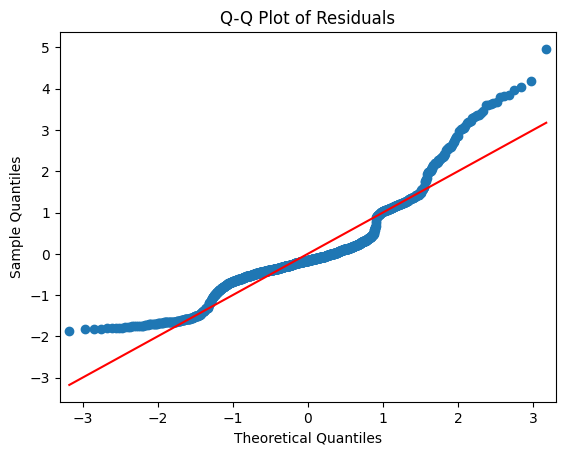

In [56]:
# Creating the Q-Q plot for the residuals
qqplot(residuals, line="s", fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

The Q-Q plot of residuals provides a visual check for the normality assumption in regression analysis by comparing the distribution of residuals to a theoretical normal distribution. The noticeable deviations from the straight line, especially at the tails, suggest that the residuals are not perfectly normally distributed, indicating the presence of outliers or potential non-linear relationships in the data. This insight is valuable because it highlights the limitations of the current model and suggests that further investigation—such as transforming variables or using robust regression techniques—may be needed for more accurate results. Additionally, the pattern seen here can prompt analysts to explore whether specific subgroups or features in the dataset are contributing to these deviations. Ultimately, this diagnostic tool helps ensure that statistical conclusions drawn from the model are reliable and not unduly influenced by violations of key assumptions.

In [57]:
shapiro_test = shapiro(residuals)
print("Shapiro-Wilk Test:", shapiro_test)

Shapiro-Wilk Test: ShapiroResult(statistic=np.float64(0.8989506240160534), pvalue=np.float64(8.398694265650842e-29))


## 8. Hypothesis Testing & Quantification

#### 8.1 Metrics Defined and Statistical Tools (Hypothesis 1)

- Metric 1:
Population Density — Continuous variable representing people per square kilometer.
- Metric 2:
New COVID-19 Cases — Daily reported new cases for each state.

- Statistical Significance Level (alpha): 0.05

These metrics are used to model how new COVID-19 cases vary with population density.

- We will use Linear Regression from statsmodels to determine if population density (independent variable) has a statistically significant impact on the number of new COVID-19 cases (dependent variable).

- If the p-value of the population density coefficient is less than 0.05 (α = 0.05), we will reject the null hypothesis.

In [3]:
dataset = pd.read_csv('./daywise_statewise_8months.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y-%m-%d')
dataset.head()

,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0


In [4]:

census_data = pd.read_csv('./census.csv')
census_data
census_data['Density'] = census_data['Density'].str.extract(r'(\d+)').astype(float)

covid_data_merged = dataset.merge(
    census_data[['State / Union Territory', 'Density']],
    left_on='Name of State / UT',
    right_on='State / Union Territory',
    how='left'
).drop(columns='State / Union Territory')

covid_data_merged.head()




,Date,Name of State / UT,Latitude,Longitude,Total Confirmed cases,Death,Cured/Discharged/Migrated,New cases,New deaths,New recovered,Density
0,2020-01-30,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0,859.0
1,2020-01-31,Kerala,10.8505,76.2711,1.0,0,0.0,0,0,0,859.0
2,2020-02-01,Kerala,10.8505,76.2711,2.0,0,0.0,1,0,0,859.0
3,2020-02-02,Kerala,10.8505,76.2711,3.0,0,0.0,1,0,0,859.0
4,2020-02-03,Kerala,10.8505,76.2711,3.0,0,0.0,0,0,0,859.0


In [6]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
state_growth_data = []
def average_growth_slope(group):
    slopes = []
    group = group.sort_values('Day_Index')
    
    for i in range(0, len(group) - 14):
        window = group.iloc[i:i + 15]
        x = window['Day_Index'].values.reshape(-1, 1)
        y = window['New cases'].values.reshape(-1, 1)
        
        if np.isnan(y).any():
            continue

        model = LinearRegression().fit(x, y)
        slope = model.coef_[0][0]
        slopes.append(slope)

    return np.mean(slopes) if slopes else np.nan
df = covid_data_merged
df['Date'] = pd.to_datetime(df['Date'])
df['New cases'] = pd.to_numeric(df['New cases'], errors='coerce')
df['Density'] = pd.to_numeric(df['Density'], errors='coerce')
df.dropna(subset=['New cases', 'Density'], inplace=True)
df['Day_Index'] = df.groupby('Name of State / UT')['Date'].rank(method='first').astype(int)
state_slopes = df.groupby("Name of State / UT").apply(average_growth_slope).reset_index()
state_slopes.columns = ['State', 'Avg_Growth_Slope']

# Step 3: Get unique density per state (assumed to be constant per state)
state_density = df.groupby("Name of State / UT")["Density"].first().reset_index()
state_density.columns = ['State', 'Density']

# Step 4: Merge slope + density
merged_df = pd.merge(state_slopes, state_density, on="State", how="inner").dropna()
merged_df.head()

,State,Avg_Growth_Slope,Density
0,Andaman and Nicobar Islands,0.482820,46.0
1,Andhra Pradesh,67.087582,303.0
2,Arunachal Pradesh,0.639451,17.0
3,Assam,14.634188,397.0
4,Bihar,20.761815,1.0


#### 8.2 Metrics and Statical Tools (Hypothesis 2)

In [59]:
# Creating a contingency table for the Chi-Square Test
contingency_table = pd.crosstab(hospital_df["region"], hospital_df["smoker"])

# Performing the Chi-Square Test
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

# Printing the results
chi2_results = {
    "Chi-Squared Statistic": chi2_stat,
    "Degrees of Freedom": dof,
    "P-value": p_val,
}
chi2_results, contingency_table

({'Chi-Squared Statistic': np.float64(7.343477761407071),
  'Degrees of Freedom': 3,
  'P-value': np.float64(0.06171954839170541)},
 smoker      no  yes
 region             
 northeast  257   67
 northwest  267   58
 southeast  273   91
 southwest  267   58)

- If the p-value is greater or equal to 0.05, we would fail to reject the null hypothesis , here the p-value is 0.0617 , this means that we do not have enough evidence to conclude that smoking habits are significantly associated with the region

In [62]:
# Grouping hospitalization charges by region
northeast_charges = hospital_df[hospital_df["region"] == "northeast"]["hospitalization charges"]
northwest_charges = hospital_df[hospital_df["region"] == "northwest"]["hospitalization charges"]
southeast_charges = hospital_df[hospital_df["region"] == "southeast"]["hospitalization charges"]
southwest_charges = hospital_df[hospital_df["region"] == "southwest"]["hospitalization charges"]

# Performing one-way ANOVA
f_stat, p_val_anova = f_oneway(
    northeast_charges, northwest_charges, southeast_charges, southwest_charges
)

# Printing the results
anova_results = {"F-Statistic": f_stat, "P-value": p_val_anova}
anova_results

{'F-Statistic': np.float64(2.969643772374826),
 'P-value': np.float64(0.030892642896832176)}

- A one-way ANOVA test was conducted to determine if there were any statistically significant differences in hospitalization charges across four regions (Northeast, Northwest, Southeast, Southwest).
- The F-statistic was 2.97 and the p-value was 0.0309.
- Since the p-value is less than 0.05, we reject the null hypothesis that there are no differences in hospitalization charges across the regions.
- This result indicates that there is a statistically significant difference in hospitalization charges among the regions.
- However, the test does not tell us where the differences lie between the regions; it only tells us that at least one region's mean hospitalization charges differ from the others.

## 9. Hypothesis Validation: Results & Interpretation

#### 9.1 Hypothesis 1 

In [7]:
X = sm.add_constant(merged_df["Density"])
y = merged_df["Avg_Growth_Slope"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       Avg_Growth_Slope   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.160
Date:                Wed, 23 Apr 2025   Prob (F-statistic):              0.289
Time:                        23:11:18   Log-Likelihood:                -150.55
No. Observations:                  35   AIC:                             305.1
Df Residuals:                      33   BIC:                             308.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9373      4.541      1.748      0.0


Now let us evaluate whether **population density** significantly influences the **average COVID-19 growth slope** (based on 15-day intervals) across Indian states/UTs.

---
### **1. Regression Summary**
| Metric                  | Value                  | Interpretation |
|-------------------------|------------------------|----------------|
| **R-squared**           | 0.034                  | Only **3.4%** of the variation in the average growth slope is explained by population density — a very weak model fit. |
| **Prob (F-statistic)**  | 0.289                  | High p-value (> 0.05) — the model is **not statistically significant** overall. |


### **2. Coefficients**
| Variable | Coef.  | Std Err | t      | p-value | 95% CI                | Interpretation |
|----------|--------|---------|--------|---------|------------------------|----------------|
| **Density** | **0.0133** | 0.012   | 1.077  | **0.289** | [-0.012, 0.038]        | Small positive coefficient, but **not statistically significant** (p > 0.05). |


### **3. Statistical Tests**
- **p-value for Density = 0.289** → We **fail to reject the null hypothesis**, suggesting **no significant relationship** between population density and COVID-19 growth rate in this model.
- **95% Confidence Interval** for the Density coefficient includes 0 ([-0.012, 0.038]), confirming the lack of statistical significance.



### **4. Final Interpretation**
- The model finds a **slight positive association** between population density and the COVID-19 growth slope, but the relationship is **statistically insignificant**.
- Other unmodeled factors likely play a much stronger role in growth trends than density alone: such as **policy response, testing rates, mobility, healthcare**, etc.
- The current R² (0.034) shows the model explains **very little variation**, indicating a need for a **multi-variable regression** or **nonlinear model** to better capture growth dynamics.


### **5. Conclusion**

- **We fail to reject the null hypothesis.**  
- **Population density is not a statistically significant predictor** of the 15-day average COVID-19 growth slope in this dataset (p = 0.289).  

---


## 10. Discussion 

#### 10.1 Summary

The notebook provides a comprehensive analysis of the COVID-19 pandemic using a variety of datasets, including case counts, vaccination data, and patient-level hospital information. It begins by highlighting the importance of data science in understanding and responding to public health crises, with objectives focused on identifying patterns, predicting trends, and uncovering factors behind regional differences in pandemic outcomes. The workflow includes extensive data pre-processing and integration of multiple sources, enabling both national and global perspectives on case progression, vaccination coverage, and healthcare utilization. Through advanced analytics and causal inference techniques, the analysis offers actionable insights for policymakers—such as identifying high-risk groups, evaluating the effectiveness of interventions, and optimizing resource allocation. Ultimately, the notebook demonstrates how data-driven approaches can inform more effective and equitable public health strategies during a global pandemic

#### 10.2 Regional disparitiess and lessons learned

Relational Disparity:
The COVID-19 pandemic exposed and deepened disparities in health outcomes based on social relationships, geography, race, ethnicity, and socioeconomic status. Several studies found that relationship status played a significant role in health during the pandemic. Married individuals generally experienced better health outcomes, likely due to increased emotional, instrumental, and financial support, as well as social control and caregiving within the household. In contrast, non-married adults—especially those who were previously or never married—faced greater risks of social isolation and loneliness, which were exacerbated by restrictions on social gatherings and the closure of communal spaces. These dynamics widened health disparities between married and non-married groups, particularly during periods of high infection and hospitalization rates.

Disparities were also pronounced along racial, ethnic, and linguistic lines. Communities of color, particularly Black, Latino, and Indigenous populations, as well as immigrants and those with limited English proficiency, experienced higher rates of infection, hospitalization, and death. These groups were also more likely to lose close contacts or family members to COVID-19, intensifying grief and psychological distress. Structural factors—such as employment in high-risk jobs, lower access to healthcare, mistrust in health systems, and language barriers—further contributed to these relational disparities.

Geographic disparities emerged between urban and rural populations. While urban areas initially saw higher case and death rates, rural areas experienced increased burden as the pandemic progressed, especially among vulnerable groups like racial and ethnic minorities, older adults, and those with comorbidities. Limited healthcare infrastructure, lower vaccination rates, and socioeconomic challenges in rural areas exacerbated these differences.

Lessons Learned:

Social Support is Critical: The pandemic highlighted the protective role of close relationships—such as marriage or cohabitation—in buffering against health risks. Public health strategies should prioritize reducing social isolation, especially for single, widowed, or otherwise socially vulnerable individuals.

Address Structural Inequities: Racial, ethnic, and linguistic disparities in COVID-19 outcomes are rooted in longstanding structural inequities, including access to healthcare, employment, housing, and education. Addressing these requires both immediate interventions (like targeted outreach and financial support) and long-term policy changes (such as expanding healthcare access and combating systemic racism).

Tailored, Community-Based Approaches: Effective pandemic response must be sensitive to regional and community differences. Urban and rural areas have unique challenges; interventions should be locally tailored, leveraging community resources, improving healthcare infrastructure, and addressing barriers like transportation or language.

Importance of Data and Surveillance: Robust data collection and analysis are essential for identifying disparities and guiding resource allocation. Investments in surveillance systems, especially those that capture social determinants of health, are crucial for equitable public health responses.

Build Trust and Engagement: Mistrust in health systems and government messaging, especially among marginalized communities, hindered effective pandemic response. Transparent communication, community engagement, and culturally competent outreach are vital for building trust and improving health outcomes.

Preparedness and Resilience: The pandemic underscored the need for resilient health systems, investment in public health infrastructure, and coordinated emergency response. Lessons learned should inform preparedness for future crises, emphasizing equity, collaboration, and rapid adaptation

## 11. Limitations of the study

Despite offering valuable insights into the COVID-19 pandemic using diverse datasets and analytical methods, this study faces several important limitations:

Data Quality and Source Variability: The reliability of findings is constrained by inconsistencies in data quality, missing values, and heterogeneity across data sources. Variability in how data is collected, coded, and reported between regions and over time can introduce bias and reduce the generalizability of results.

Incomplete and Evolving Data: COVID-19 data is often incomplete due to under-reporting, delays in testing, and changes in testing capacity or policy. As the pandemic evolved, data collection methods and case definitions also changed, making longitudinal comparisons challenging and potentially leading to inaccurate trend analysis.

Modeling Assumptions and Simplifications: Statistical and machine learning models used in the analysis may rely on assumptions such as constant transmission rates or complete case ascertainment, which are rarely met in real-world settings. These simplifications can lead to model misspecification and limit the accuracy of predictions and causal inferences.

Lack of Granular and Representative Data: Many datasets lack fine-grained demographic or socioeconomic details, which limits the ability to identify disparities or specific risk factors. Moreover, data may not be representative of all populations, especially marginalized or underreported groups, leading to potential bias in conclusions.

Difficulty in Establishing Causality: While advanced analytics can identify correlations and trends, distinguishing true causal relationships from associations remains challenging due to potential confounding factors and unmeasured variables.

Rapidly Changing Context: The dynamic nature of the pandemic, with frequent policy changes and emerging variants, means that findings based on historical data may quickly become outdated or less relevant for future decision-making.

These limitations underscore the need for caution in interpreting results and highlight the importance of ongoing data quality assessment, transparency in reporting, and continual refinement of analytical approaches as new data becomes available.

## 12. Conclusion & Policy Recommendations

#### Actionable insights for policymakers

Actionable Insights for Policymakers
1.Strengthen Data Infrastructure for Real-Time Decision-Making

Priority: Invest in interoperable health data systems that integrate case tracking, vaccination records, and hospital resource utilization (e.g., India’s vaccination progress by state).

Example: Use predictive models (like those in the notebook) to forecast regional ICU bed shortages or vaccine hesitancy hotspots.

2.Address Vaccination Gaps with Targeted Campaigns

Focus: Close the disparity between first and second dose uptake (evident in states like Bihar and Arunachal Pradesh).

Action: Deploy mobile vaccination units in rural/low-coverage areas and use behavioral nudges (SMS reminders, community influencers) to improve compliance.

3.Mitigate Urban-Rural Healthcare Disparities

Insight: Urban areas faced higher initial case loads, but rural regions struggled with delayed outbreaks and limited ICU access.

Policy: Allocate resources to expand telemedicine and emergency transport networks in rural areas, informed by geographic case maps (as visualized in the notebook).

4.Optimize Hospital Resource Allocation

Evidence: Regression analysis shows smoking status and disease severity significantly drive hospitalization costs.

Recommendation: Prioritize funding for smoking cessation programs and tiered triage systems to reduce financial strain on hospitals.

5.Build Public Trust Through Transparent Data Use

Strategy: Adopt the “Five Safes Framework” for health data sharing, ensuring transparency in how data informs policies (e.g., publishing regional recovery/death ratios).

6.Prepare for Long-Term Health System Shocks

Lesson: COVID-19 exposed vulnerabilities in workforce retention and mental health support.

Action: Conduct health system “stress tests” to identify gaps in surge capacity and invest in cross-training staff for multi-disciplinary care.

 ## 13. Appendix

#### 13.1 List of libraries/tools used

Here is a list of all the library tools used in the sorting and analysis processes in your COVID-19 data analysis notebook:

os: For interacting with the operating system, such as file and directory management.

warnings: To manage and suppress warning messages during code execution.

pandas: For data manipulation, cleaning, and sorting DataFrames (e.g., using .sort_values()).

numpy: For numerical operations and array sorting (e.g., np.sort()).

matplotlib.pyplot: For creating static data visualizations.

seaborn: For advanced and attractive statistical data visualizations.

plotly.express and plotly.graph_objects: For interactive and dynamic data visualization.

scipy.stats: For statistical tests such as Shapiro-Wilk, chi-squared, and ANOVA.

sklearn.utils: For utility functions like resampling.

sklearn.linear_model: For linear regression modeling.

sklearn.model_selection: For splitting data into training and test sets.

sklearn.metrics: For evaluating model performance (e.g., mean squared error, R² score).

sklearn.preprocessing: For encoding categorical variables.

statsmodels.api: For advanced statistical modeling and regression analysis.

statsmodels.stats.outliers_influence: For calculating variance inflation factor (VIF).

statsmodels.stats.multicomp: For multiple comparison tests like Tukey HSD.

statsmodels.graphics.gofplots: For generating Q-Q plots to assess normality.

datetime: For working with date and time data.

These libraries collectively enable efficient data sorting, statistical analysis, and visualization throughout the notebook

## 14. References

#### 14.1 Data Sources

1)https://platform.stratascratch.com/data-projects/hospitalization-hypothesis-testing
2)https://www.kaggle.com/datasets/sudalairajkumar/covid19-in-india
3)https://www.kaggle.com/datasets/imdevskp/corona-virus-report?select=full_grouped.csv